<div class="alert alert-block alert-info">
<span style="color: rgb(0,53,91);">
<center><img src="https://imgs.search.brave.com/vIujYFx1qV5CoxJb72HNVYIoBXQjuasIvdngB1DPC3s/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly91cGxv/YWQud2lraW1lZGlh/Lm9yZy93aWtpcGVk/aWEvZW4vdGh1bWIv/NS81Zi9XZXN0ZXJu/X0luc3RpdHV0ZV9v/Zl9UZWNobm9sb2d5/X2FuZF9IaWdoZXJf/RWR1Y2F0aW9uX2xv/Z28ucG5nLzIwMHB4/LVdlc3Rlcm5fSW5z/dGl0dXRlX29mX1Rl/Y2hub2xvZ3lfYW5k/X0hpZ2hlcl9FZHVj/YXRpb25fbG9nby5w/bmc" style="width:180px;height:142px;" title="Logo ITESO"></center>
<font face = "Times New Roman" size = "6"><b><center>Programacion para Mineria de Datos</center></b></font>
<font face = "Times New Roman" size = "5"><b><center>TAREA: Fuga de Datos</center></b></font>

<b><font back = "Times New Roman" size = "4"><center>Unidad 4: </center></font>
<font face = "Times New Roman" size = "4"><center>Tema 4.3: Integración de Datos: Categóricos, Numéricos, Faltantes y Fuga de Datos</center></font>

<b><font back = "Times New Roman" size = "4"><center>Equipo: </center></font>
<font face = "Times New Roman" size = "4"><center> Diego Lemus, Sebastian Zinchenko, Jersus Vargas </center></font>

<div align="right"><font face = "Times New Roman" size = "2">Mtro. Miguel Tlapa Juarez (migueltlapa@iteso.mx)</font></div>
</span></div>




In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import RandomState
from pandas.core.common import random_state
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
import seaborn as sns
from scipy.stats import norm
from unicodedata import numeric



# Cargamos CSV

In [14]:
data = "data/datos_processing_integration.csv"
df = pd.read_csv(data)
print(df.shape)
df.head()

(120, 12)


,edad,ingreso_mensual,talla_cm,peso_kg,temperatura_c,frecuencia_cardiaca,ciudad,tipo_servicio,nivel,codigo_serie,referencia,sensor_defectuoso
0,2.152350,32.363455,73.0,17.0,1344.359160,NaN,A,azul,bajo,NaN,tagD,74.193076
1,7.527457,NaN,610.0,5.0,1034.626809,0.349578,NaN,verde,medio,X,NaN,NaN
2,3.258677,43.865147,421.0,11.0,1301.186344,1.084957,A,rojo,bajo,Z,tagB,NaN
3,4.481654,76.347980,200.0,6.0,1494.730860,0.343660,A,rojo,alto,Z,tagD,NaN
4,NaN,62.913846,307.0,18.0,856.347865,0.543502,A,NaN,medio,Z,tagC,NaN


# Splitting

In [57]:
#Traning environment with a random splitting and then shuffle them
X_train, X_test = train_test_split(df, test_size=0.20, random_state=12, shuffle=True)

#Including numbers from our new list
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
#Excluding numbers from our new list
cat_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()

print(f"num: {num_cols}")
print(f"categorical: {cat_cols}")

num: ['edad', 'ingreso_mensual', 'talla_cm', 'peso_kg', 'temperatura_c', 'frecuencia_cardiaca', 'sensor_defectuoso']
categorical: ['ciudad', 'tipo_servicio', 'nivel', 'codigo_serie', 'referencia']


# Histograma de dispersion


4.957169392285077
1.8918428639291585


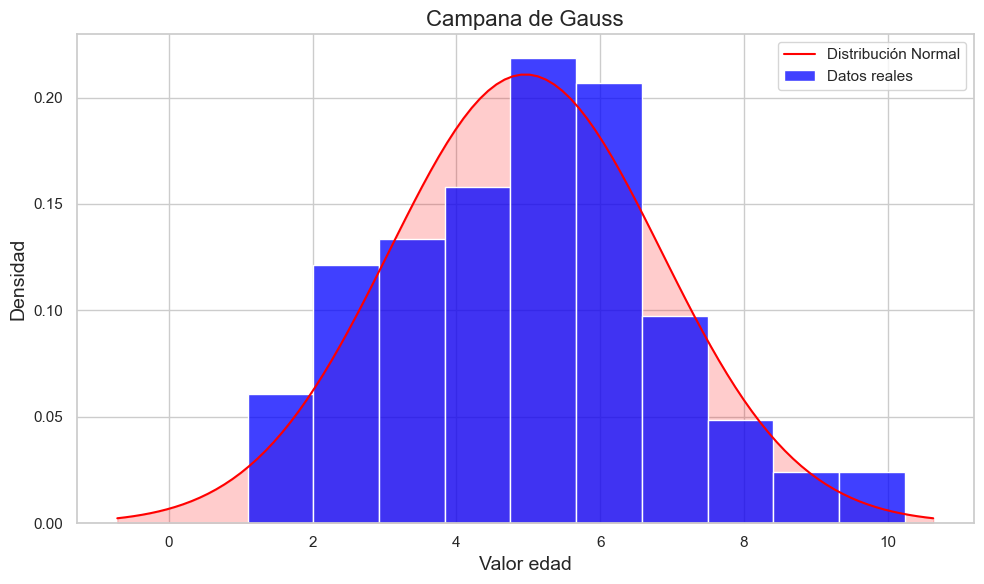

4.957169392285077
1.8918428639291585


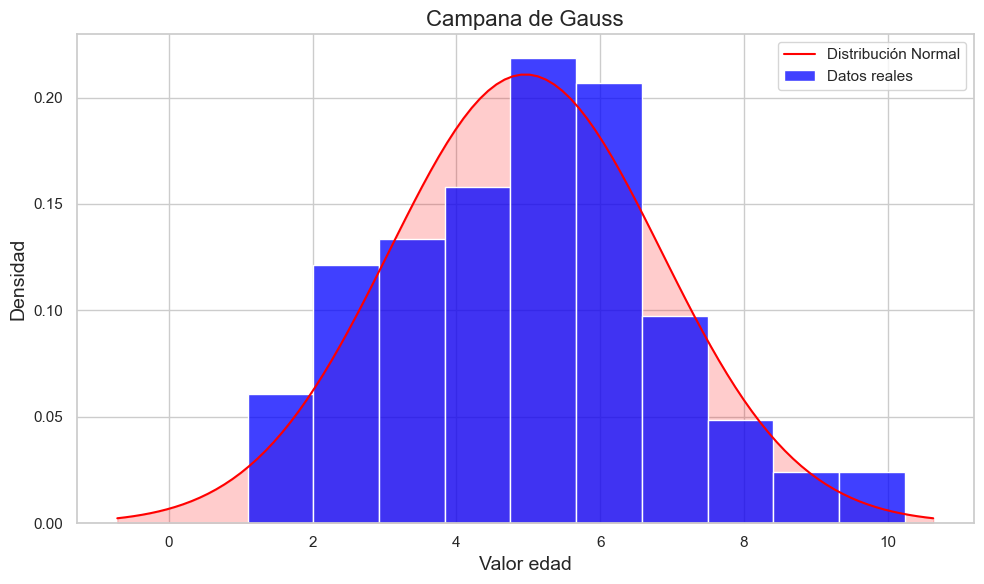

49.68538133414594
15.421190309902638


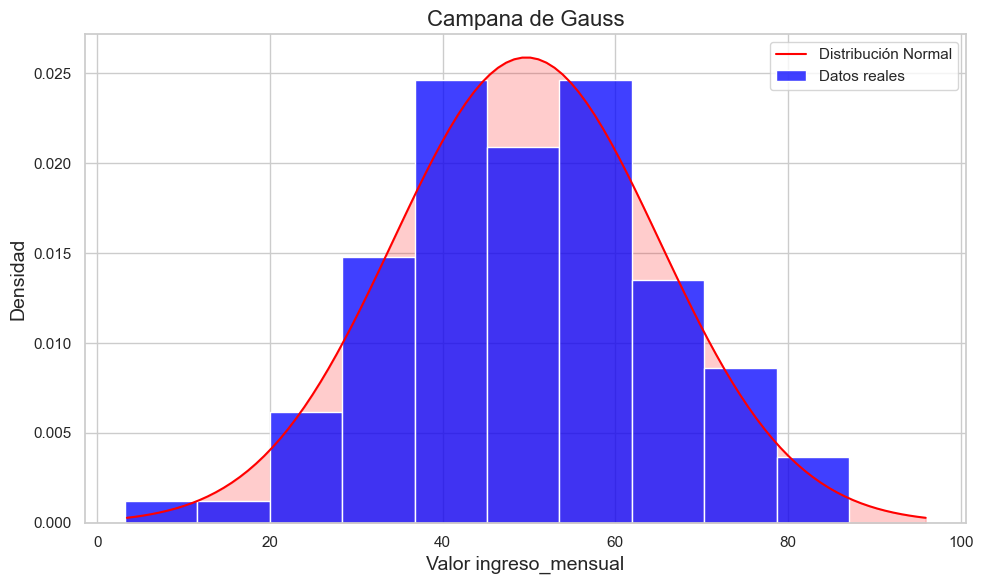

431.64356435643566
212.82882929103934


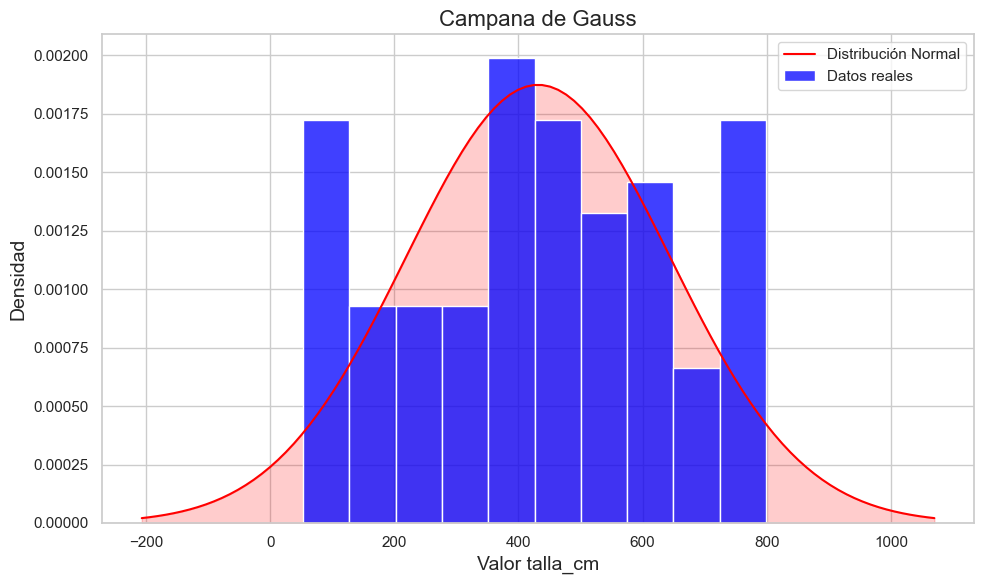

14.631067961165048
5.696175332849731


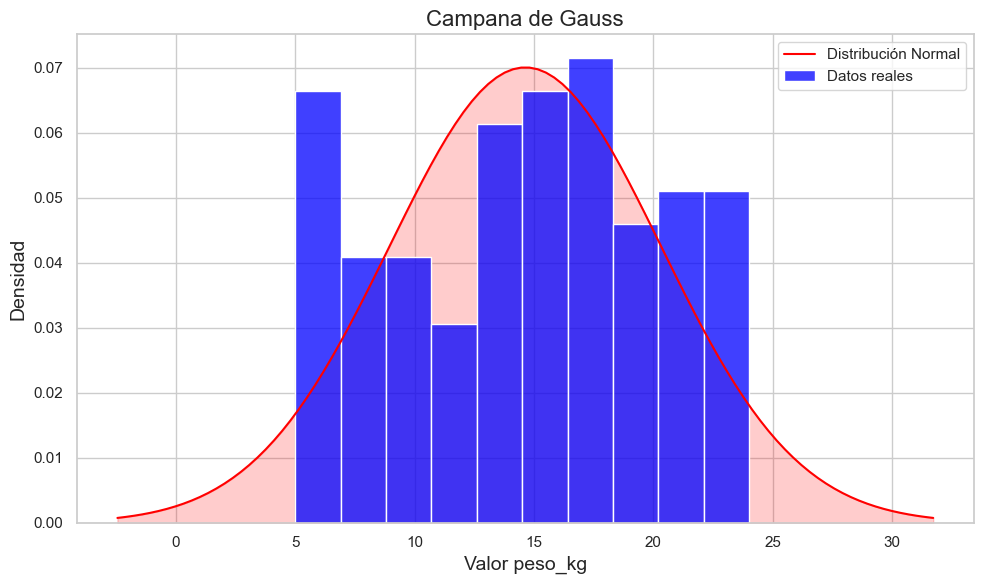

1222.5200240807264
246.01151416472766


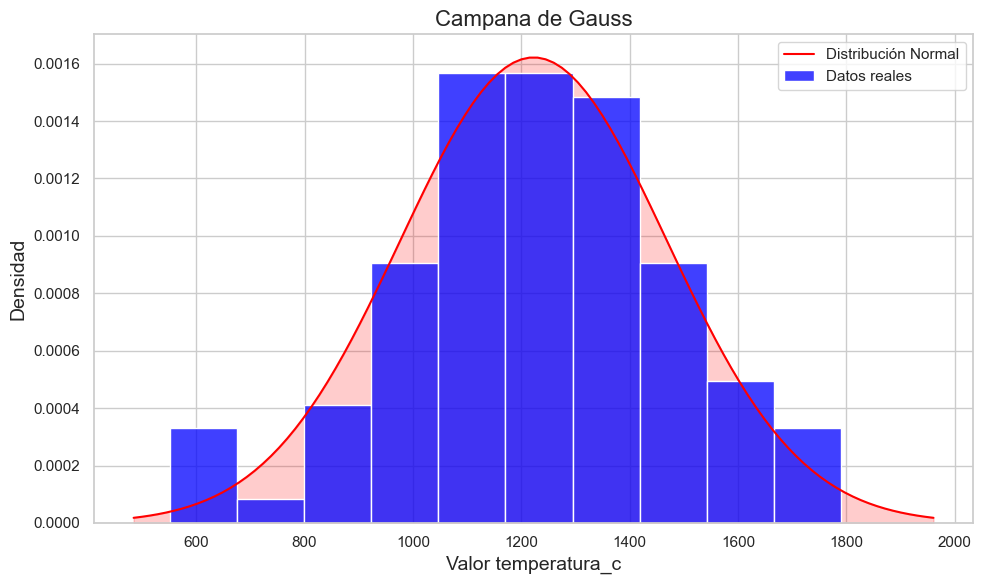

0.6169254730401804
0.32337368166495734


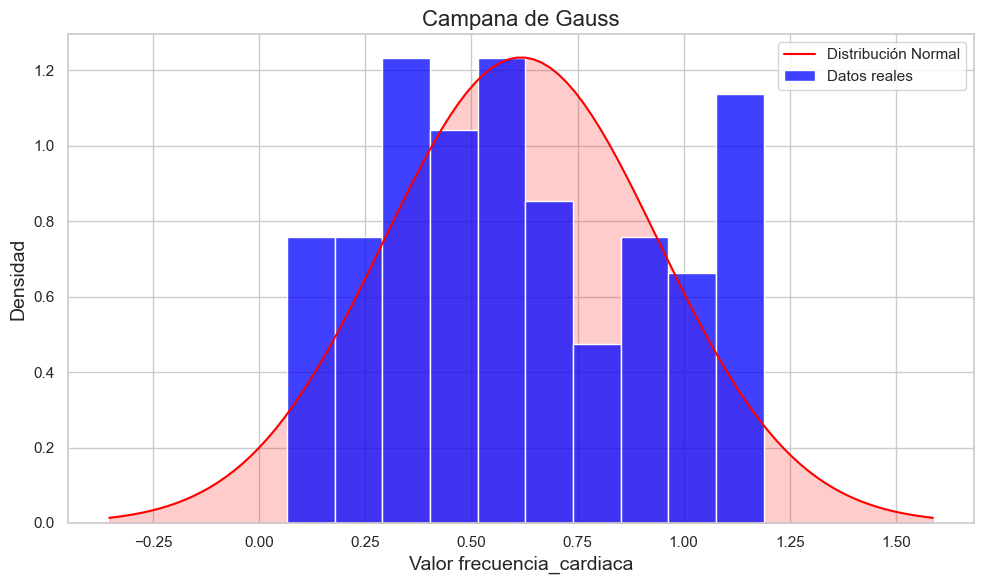

In [36]:
columns = ['edad','ingreso_mensual','talla_cm','peso_kg','temperatura_c','frecuencia_cardiaca']
def hist_dist_normal(df, column):

    escalado = df[column]

    media = np.mean(escalado)
    desviacion = np.std(escalado)
    print(media)
    print(desviacion)

    x = np.linspace(media - 3*desviacion, media + 3*desviacion, 100)
    y = norm.pdf(x, media, desviacion)

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    plt.plot(x, y, color='red', label='Distribución Normal')
    plt.fill_between(x, y, color='red', alpha=0.2)

    sns.histplot(escalado, kde=False, stat='density', bins=10, color='blue', edgecolor='white', label='Datos reales')

    plt.title('Campana de Gauss', fontsize=16)
    plt.xlabel('Valor {}'.format(column), fontsize=14)
    plt.ylabel('Densidad', fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()
for column in columns:
    hist_dist_normal(X_train,column)

# Deteccion de Outliers

In [56]:
def outliers_summary(df_in: pd.DataFrame, numeric_cols):
    rows = []
    for col in numeric_cols:
        s_raw = pd.to_numeric(df_in[col], errors='coerce')
        s = s_raw.dropna()

        #formato empty para mostrar lo que se necesita para aplicar la heuristica
        if s.empty:
            rows.append({
                "outliers_n": 0, "outliers_%": 0.0, "|skew|": np.nan,
                "recom_imputer": "median", "imputer_to_use": "RobustScaler"
            })
            continue

        q1, q3 = s.quantile(0.25), s.quantile(0.75)
        #rango intercuartilar
        iqr = q3 - q1
        #limites
        lim_inf, lim_sup = q1 - 1.5*iqr, q3 + 1.5*iqr
        #mascara para contar los outliers
        mask = (s < lim_inf) | (s > lim_sup)
        out_n = int(mask.sum())
        out_pct = 100.0 * out_n / len(s)

        skew_abs = float(abs(s.skew()))

        # Heurística de IMPUTACIÓN
        imputer = "median" if (out_pct >= 5.0 or skew_abs >= 1.0) else "mean"
        # Heurística de ESCALADO
        if out_pct >= 5.0:
            scaler = "RobustScaler"
        elif skew_abs <= 0.5:
            scaler = "StandardScaler"
        else:
            scaler = "MinMaxScaler"

        rows.append({
            "| columna |": col,
            "| outliers_n |": out_n, "outliers_%": round(out_pct, 2),
            "| skew |": round(skew_abs, 3),
            "imputer_to_use": imputer,
            "scaler_to_use": scaler
        })

    rep = pd.DataFrame(rows).sort_values("outliers_%", ascending=False).reset_index(drop=True)
    return rep


print(outliers_summary(X_train,num_cols))

           | columna |  | outliers_n |  outliers_%  | skew | imputer_to_use  \
0        temperatura_c               3        4.05     0.312           mean   
1      ingreso_mensual               1        1.35     0.114           mean   
2                 edad               0        0.00     0.259           mean   
3             talla_cm               0        0.00     0.007           mean   
4              peso_kg               0        0.00     0.185           mean   
5  frecuencia_cardiaca               0        0.00     0.082           mean   
6    sensor_defectuoso               0        0.00     0.734           mean   

    scaler_to_use  
0  StandardScaler  
1  StandardScaler  
2  StandardScaler  
3  StandardScaler  
4  StandardScaler  
5  StandardScaler  
6    MinMaxScaler  


# Consluiones

### **Diego Lemus**:
#### Realicé un preprocesamiento sistemático para asegurar la calidad e integridad de los datos: separé primero en entrenamiento y prueba para evitar fuga, analicé distribución y atípicos, y apliqué una heurística  para imputar y escalar. Las variables categóricas se codificaron (ordinal y one-hot).

### **Sebastien Zinchenko**:

### **Jesus Vargas**:
#### A lo largo de este ejercicio se aplicaron diversas técnicas fundamentales del preprocesamiento de datos, las cuales son esenciales en la minería de datos y el aprendizaje automático. Se comprendió la importancia de limpiar, escalar y analizar la calidad del dataset antes de usarlo en cualquier modelo predictivo.


# Categorizacion

In [65]:
# Nominales (One-Hot). Uso cat cols a excepcion de nivel
onehot_cols = [c for c in cat_cols if c != "nivel"]

# Ordinales
ordinal_cols = ["nivel"]
ordinal_categories = {"nivel": ["bajo","medio","alto"]}

# Imputacion de categóricas

In [66]:
cat_imp = SimpleImputer(strategy="most_frequent")
# categorical imputer fit - aprende cual es la moda en X train, solo lo haces con train para rellenar los valores valtantes
cat_imp.fit(X_train[onehot_cols + ordinal_cols])

#datafranes sin nulos
Xtr_cat = pd.DataFrame(
    cat_imp.transform(X_train[onehot_cols + ordinal_cols]),
    columns=onehot_cols + ordinal_cols, index=X_train.index
)
Xte_cat = pd.DataFrame(
    cat_imp.transform(X_test[onehot_cols + ordinal_cols]),
    columns=onehot_cols + ordinal_cols, index=X_test.index
)

# Ordinal

In [69]:
from sklearn.preprocessing import OrdinalEncoder


ordenc = OrdinalEncoder(
    categories=[ordinal_categories["nivel"]],
    handle_unknown="use_encoded_value",
    #vimos en clase que si hay una categoria vista se le asigne -1
    unknown_value=-1
)
ordenc.fit(Xtr_cat[ordinal_cols])

#DataFrame de Ordinal para entrenamiento (X Train Ordinal)
Xtr_ord = pd.DataFrame(
    ordenc.transform(Xtr_cat[ordinal_cols]),
    columns=[f"ORD_{c}" for c in ordinal_cols],
    index=X_train.index
)
#DataFrame de Ordinal para testing (X test Ordinal)
Xte_ord = pd.DataFrame(
    ordenc.transform(Xte_cat[ordinal_cols]),
    columns=[f"ORD_{c}" for c in ordinal_cols],
    index=X_test.index
)


# One-Hot

In [70]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd


if onehot_cols:

    #aplicamos on hot ignorando los unknowns
    ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    ohe.fit(Xtr_cat[onehot_cols])

    #One-Hot encoder data frame de entrenamiento (X Test One.Hot.Encoder)
    Xtr_ohe = pd.DataFrame(
        ohe.transform(Xtr_cat[onehot_cols]),
        #sacamos los titulos
        columns=ohe.get_feature_names_out(onehot_cols),
        index=X_train.index
    )
    #One-Hot encoder data frame de testing (X Train One.Hot.Encoder)
    Xte_ohe = pd.DataFrame(
        ohe.transform(Xte_cat[onehot_cols]),
         #sacamos los titulos
        columns=ohe.get_feature_names_out(onehot_cols),
        index=X_test.index
    )
else:
    Xtr_ohe = pd.DataFrame(index=X_train.index)
    Xte_ohe = pd.DataFrame(index=X_test.index)


# Reconstruccion

In [73]:
#Creamos dataset exclusivamente para los datos categoricos cosificados
X_train_cat_only = pd.concat([Xtr_ohe.reset_index(drop=True),
                              Xtr_ord.reset_index(drop=True)], axis=1)
X_test_cat_only  = pd.concat([Xte_ohe.reset_index(drop=True),
                              Xte_ord.reset_index(drop=True)], axis=1)

X_train_cat_only.to_csv(f"Solo_Categoricos_train.csv")
X_test_cat_only.to_csv("Solo_Categoricos_test.csv")